# `TODO`  

``` HTML
[ANALYSE]   >> Divide metric into grids and compute distances with variance of groups -- <DONE>
[ANALYSE]   >> Find way to compute 'correlation' between space-metric space plots -- <DONE> (TSNE-PLOTS!)
[VISUALIZE] >> TSNE embedding in space-metric plot -- <DONE>
```

---

# Imports

In [1]:
import sys
import os

In [2]:
import math

---

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [6]:
import seaborn as sns

In [7]:
import scipy as sc

In [8]:
from sklearn.manifold import TSNE

---

In [9]:
import mat73

---

In [10]:
import neuropythy as ny

In [11]:
import nibabel as nib

In [12]:
# import hcp_utils as hcp

---

---

In [13]:
import logging

## Config

In [14]:
logging.getLogger().setLevel(logging.INFO)

---
# Functions

In [15]:
def get_coors(sid=100610, volume_space='native', surface_mesh='fs_lr_low', surface_type='midthickness', msm_alignment_method='msmall', hemisphere='both', directory='hcp-subjects'):
    """Gets the grayordinate coordinates of a subject for the given volume and surface space, surface type, surface alignment method, and hemisphere. 

    Parameters
    ----------
    sid : int, optional
        Serial ID of the participant, by default 100610.
    volume_space : {'native', 'mni'}, optional
        The volume space for the coordinates, by default 'native'.
    surface_mesh : {'native', 'fs_lr_high', 'fs_lr_med', 'fs_lr_low'}, optional
        The surface mesh for the coordinates, by default 'native'.
    surface_type : {flat, white, pial, midthickness, sphere, inflated, very_inflated}, optional
        The surface type for the coordinates, by default 'midthickness'.
    msm_alignment_method: {'msmsulc', 'msmall', None}, optional
        The surface alignment method used by MSM, by default 'msmall'.
    hemisphere : {'left', 'right', 'both'}, optional
        The hemisphere to get coordinates for, by default 'both'.
    directory : str, optional
        The path to HCP subjects root directory under './data/', by default 'hcp-subjects'.

    Returns
    -------
    np.darray
        List of 3D coordinates of the requested surface; [left_hemisphere_vertices; right_hemisphere_cortices]. # ; subcortical_voxels
    """
    
    if msm_alignment_method is None and not surface_mesh == 'native' and surface_type not in {'flat', 'sphere'}:
        logging.warning('`None` as MSM alignment method is only valid for native surface mesh (probably also only in MNI volume space)! Defaulting to MSMAll method.')
        msm_alignment_method = 'msmall'
    
    if surface_type != 'sphere' and volume_space == 'mni' and surface_mesh == 'native':
        raise ValueError('Only spherical surface type available for native surface mesh in MNI volume space!')
    
    if volume_space == 'native' and surface_mesh == 'fs_lr_high':
        raise ValueError('164k vertex high resolution Conte69 registered standard surface mesh only available in MNI volume space!')
    
    if volume_space == 'native' and surface_mesh == 'native':
        if msm_alignment_method == 'msmall':
            logging.warning('MSMAll alignment method not available for native surface mesh in native volume space! Using MSMSulc method instead.')
        logging.info('The method is not specified in the available files for native surface mesh in native volume space. Probably MSMSulc.')
        msm_alignment_method = None
    
    volume_space_label = {'native': 'T1w', 'mni': 'MNINonLinear'}[volume_space]
    surface_mesh_label = {'native': 'Native', 'fs_lr_high': '.', 'fs_lr_med': 'fsaverage_LR59k', 'fs_lr_low': 'fsaverage_LR32k'}[surface_mesh]
    surface_mesh_label_2 = {'native': 'native', 'fs_lr_high': '164k_fs_LR', 'fs_lr_med': '59k_fs_LR', 'fs_lr_low': '32k_fs_LR'}[surface_mesh]
    # msm_alignment_method_label = 
    if surface_type in {'flat', 'sphere'}:
        if msm_alignment_method == 'msmall':
            logging.warning(f'MSMAll alignment method not available for {surface_type} surface mesh! Using MSMSulc method instead.')
        logging.info('The method is not specified in the available files for flat and spherical meshes. Probably MSMSulc.')
        msm_alignment_method_label = ''
    elif surface_mesh == 'native':
        msm_alignment_method_label = {'msmsulc': '.MSMAll', 'msmall': '.MSMSulc', None: ''}[msm_alignment_method]
    elif surface_mesh == 'fs_lr_med':
        msm_alignment_method_label = {'msmsulc': '', 'msmall': '_1.6mm_MSMAll'}[msm_alignment_method]
    else:
        msm_alignment_method_label = {'msmsulc': '', 'msmall': '_MSMAll'}[msm_alignment_method]
    
    if hemisphere == 'both':
        lh_coors = nib.load(f'data/{directory}/{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.L.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii').agg_data()[0]
        rh_coors = nib.load(f'data/{directory}/{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.R.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii').agg_data()[0]
        
        lh_atlas = nib.load(f'data/{directory}/{sid}/MNINonLinear/{surface_mesh_label}/{sid}.L.atlasroi.{surface_mesh_label_2}.shape.gii').agg_data().astype(bool)
        rh_atlas = nib.load(f'data/{directory}/{sid}/MNINonLinear/{surface_mesh_label}/{sid}.R.atlasroi.{surface_mesh_label_2}.shape.gii').agg_data().astype(bool)
        
        return np.r_[lh_coors[lh_atlas], rh_coors[rh_atlas]], ['L'] * lh_atlas.sum() + ['R'] * rh_atlas.sum()
    
    else:
        hemisphere_label = {'left': 'L', 'right': 'R'}[hemisphere]
        h_coors = nib.load(f'data/{directory}/{sid}/{volume_space_label}/{surface_mesh_label}/{sid}.{hemisphere_label}.{surface_type}{msm_alignment_method_label}.{surface_mesh_label_2}.surf.gii').agg_data()[0]
        h_atlas = nib.load(f'data/{directory}/{sid}/MNINonLinear/{surface_mesh_label}/{sid}.{hemisphere_label}.atlasroi.{surface_mesh_label_2}.shape.gii').agg_data().astype(bool)
        
        return h_coors[h_atlas], [hemisphere_label] * h_atlas.sum()

> `len(lh_coors) + len(rh_coors) + sum(lh_atlas) + sum(rh_atlas) - len(df)`  
>> $33114 = 32492 * 2 + 29696 + 29716 - 91282$

In [16]:
relu = lambda x, elbow=0.0, norm=1.0: max(x, elbow)/norm

# Load Data

In [17]:
data = mat73.loadmat('data/osfstorage-archive/prfresults.mat')

In [18]:
data.keys()

dict_keys(['allresults', 'ciftifsaveragebad', 'ciftifsaverageix', 'groupsubjectids', 'quants', 'subjectids'])

- `allresults` - is 91282 grayordinates x 6 quantities x 184 datasets x 3 model fits with the full set of pRF analysis results.  
- `quants` - is a 1 x 6 cell vector with a label for the 6 quantities: {'ang' 'ecc' 'gain' 'meanvol' 'R2' 'rfsize'}.  
- `subjectids` - is 184 x 1 with the 6-digit ID for each subject (both individual and group-average subjects).  
- `ciftifsaverageix` - is 327684 x 1 with indices into the 91282 CIFTI space. This indexing vector performs a nearest-neighbor mapping from CIFTI to FreeSurfer's fsaverage space. Note that some of the fsaverage vertices do not have a counterpart in the CIFTI space; these vertices are assigned a value of 1 in 'ciftifsaverageix'.  
- `ciftifsaveragebad` - is 327684 x 1 with logical values indicating which fsaverage vertices do not have a counterpart in the CIFTI space. These vertices should receive a NaN after performing the indexing-based mapping.  
- `groupsubjectids` - is a 1 x 3 cell vector indicating which subjects contributed to the special 999997, 999998, and 999999 group-average subjects, respectively. Each element is a vector of indices (in the range 1-181) in sorted order.

In [19]:
data["allresults"].shape

(91282, 6, 184, 3)

91282 grayordinates x 6 quantities x 184 datasets x 3 model fits

In [20]:
data["quants"]

['ang', 'ecc', 'gain', 'meanvol', 'R2', 'rfsize']

- `ang` is the angle of the estimated pRF location. Specifically, it is the angle that the center of the pRF has with respect to the positive x-axis. The range of values is 0-360 and the units are degrees. Note that when the estimated pRF is exactly at the center of gaze (i.e., eccentricity is exactly 0), then angle is ill-defined. Thus, we have explicitly set the angle to NaN for any case in which eccentricity is 0.  
- `ecc` is the eccentricity of the estimated pRF location. Specifically, it is the distance from the center of gaze to the center of the pRF. Values are greater than or equal to 0 and the units are degrees of visual angle.  
- `gain` is the BOLD response amplitude estimated in the model fit. The units are raw scanner units (same units as the time-series data in the CIFTI files). The value can be interpreted as the amplitude of the BOLD response that is predicted to result from 1 s of full-field visual stimulation.  
- `meanvol` is the mean signal intensity observed in the time-series data. The units are raw scanner units (same units as the time-series data in the CIFTI files). Note that some grayordinates have a mean signal intensity that are zero or negative, so be careful (e.g., if converting to percent BOLD signal change).  
- `R2` is the amount of variance (R-squared) in the time-series data explained by the pRF model. The values generally range from 0-100 and the units are percentages. Note that R-squared values are computed after projecting out low-order polynomials from both the time-series data and the model fit. Because of this step, R-squared values can sometimes drop below 0%.  
- `rfsize` is the size of the estimated pRF. Specifically, it is one standard deviation of a 2D Gaussian that describes the behavior of the grayordinate (see paper for details). Values are positive and the units are degrees of visual angle.

In [21]:
# Taking the results corresponding to the pRF model fit based on all data of subject 100610 #999999
df = pd.DataFrame(data["allresults"][:, :, np.argwhere(data['subjectids'] == 100610).squeeze(), 0], columns=data['quants'])
# df.head()

In [22]:
# Load standard atlases
atlases = mat73.loadmat('data/osfstorage-archive/atlas.mat')

In [23]:
print(atlases['wang2015labels'])

['Unknown', 'V1v', 'V1d', 'V2v', 'V2d', 'V3v', 'V3d', 'hV4', 'VO1', 'VO2', 'PHC1', 'PHC2', 'TO2', 'TO1', 'LO2', 'LO1', 'V3B', 'V3A', 'IPS0', 'IPS1', 'IPS2', 'IPS3', 'IPS4', 'IPS5', 'SPL1', 'FEF']


In [24]:
df['parcellation_label'] = np.array(atlases['wang2015labels'])[atlases['wang2015'].astype(int)]

In [25]:
df.head()

,ang,ecc,gain,meanvol,R2,rfsize,parcellation_label
0,78.750000,13.656000,4.231637,11666.171875,0.071830,3.620387,Unknown
1,78.750000,13.656000,360.575104,11236.359375,0.528848,1.810193,Unknown
2,356.123291,0.041699,1.978915,12020.344727,0.258905,0.044100,Unknown
3,67.500000,9.640000,4.365994,11231.982422,1.421750,10.240000,Unknown
4,302.340454,3.615990,25.726778,13231.762695,40.571110,1.205791,V3A


---

In [26]:
s100610 = ny.hcp_subject(100610)

INFO:root:HCPDataset: Getting HCP subject list...
INFO:root:       ...  Failed; falling back on builtin list.


---

In [27]:
coors, hemisphere = get_coors()

In [28]:
df[['x', 'y', 'z']] = np.nan
df['hemisphere'] = None
df.loc[:len(coors)-1, ['x', 'y', 'z']] = coors
df.loc[:len(coors)-1, ['hemisphere']] = hemisphere

---
# Main

In [29]:
roi = ['V1d', 'V1v', 'V2d', 'V2v']
roi_2 = ['V1', 'V2']

In [30]:
roi_colors = dict(zip(roi, sns.color_palette(n_colors=len(roi))))
roi_colors_2 = dict(zip(roi_2, sns.color_palette(n_colors=len(roi_2))))

roi_markers = dict(zip(roi, ['*', 'X', 'o', None])) 
roi_markers_2 = dict(zip(roi_2, ['*', 'X', 'o', None][:len(roi_2)])) 
# ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
# ('*', '+', '-', '.', '/', 'O', 'X', '\', 'o', 'x', '|')

In [31]:
dfv = df[df['parcellation_label'].isin(roi)]

In [32]:
dfv

,ang,ecc,gain,meanvol,R2,rfsize,parcellation_label,x,y,z,hemisphere
21345,336.559479,3.618743,85.077530,13151.666992,76.834282,0.648818,V2d,-16.789715,-98.847397,9.736953,L
21346,326.523804,3.701522,54.894829,13930.404297,70.235306,0.926215,V2d,-17.612337,-101.771309,8.997885,L
21347,316.761536,3.665962,39.680214,13528.439453,66.313980,0.982681,V2d,-17.478962,-104.160172,7.886327,L
21348,300.894775,3.625172,42.580318,13436.443359,62.187027,1.235554,V2d,-15.417176,-105.011490,6.610397,L
21349,284.700562,3.309399,52.515995,14081.843750,69.579498,0.943171,V2d,-13.681464,-104.856163,5.045942,L
...,...,...,...,...,...,...,...,...,...,...,...
53279,21.463928,0.155569,5.007303,11864.375000,1.730973,0.042443,V2d,1.430947,-80.844559,28.385126,R
53280,12.309883,0.194019,4.025048,11592.551758,1.689273,0.042090,V2d,1.013018,-78.791557,29.808418,R
53281,14.481833,0.188298,2.954363,11150.264648,0.954080,0.048962,V2d,3.108994,-78.490021,31.015579,R
53282,316.323700,11.318443,92.414703,11257.665039,0.695354,1.320567,V2d,5.382380,-79.581139,30.981735,R


In [33]:
%%capture --no-stdout
dfv_2 = df[df['parcellation_label'].str.contains('|'.join(roi_2))]
dfv_2.loc[:, 'parcellation_label'] = dfv.loc[:, 'parcellation_label'].str.replace(r'(V\d)\w', lambda s: s.group(1), regex=True)

---

In [34]:
CASE = 2
# 2 - No subdivisions into dorsal and ventral sections

In [35]:
if CASE == 2:
    dfv_ = dfv_2
    roi_ = roi_2
    roi_colors_ = roi_colors_2
    roi_markers_ = roi_markers_2
else:
    dfv_ = dfv
    roi_ = roi
    roi_colors_ = roi_colors
    roi_markers_ = roi_markers

## Basic Visualisation

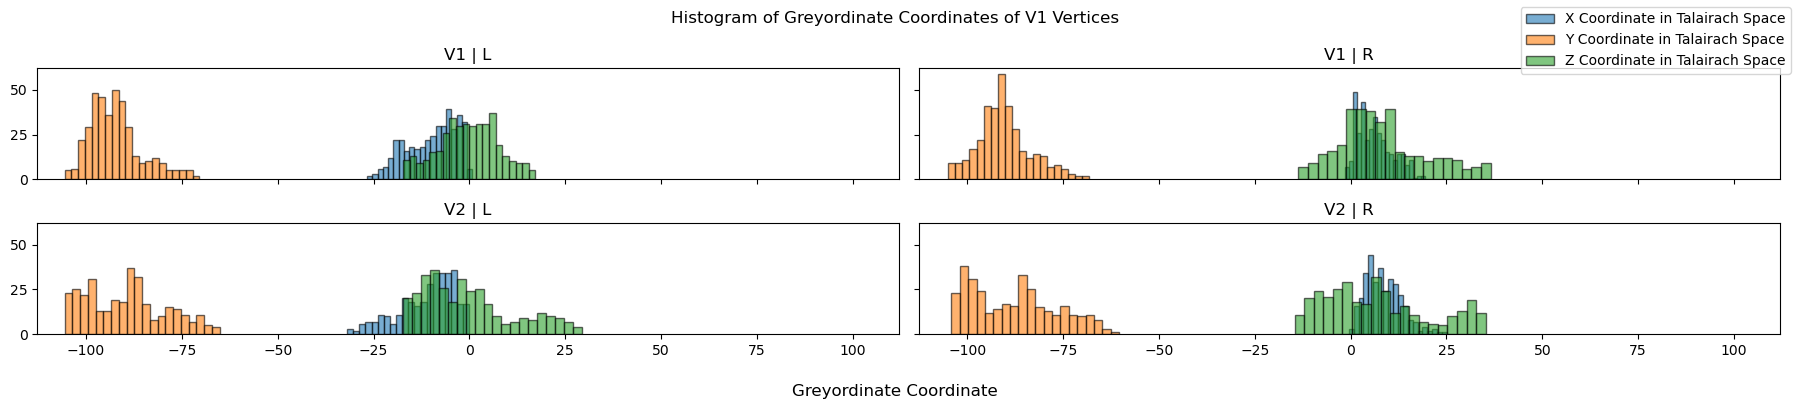

In [36]:
%matplotlib inline
fig, axs = plt.subplots(len(roi_), 2, figsize=(18, 2*len(roi_)), sharex=True, sharey=True)

for i, parcellation_label in enumerate(roi_):
    for j, hemisphere in enumerate(['L', 'R']):
        for coordinate_axis in ['x', 'y', 'z']:
            axs[i][j].hist(dfv_[(dfv['parcellation_label'].str.contains(parcellation_label)) & (dfv_['hemisphere'] == hemisphere)][coordinate_axis],
                       bins=20, edgecolor='black', alpha=0.6,
                       label=f'{f"{coordinate_axis.upper()} Coordinate in Talairach Space" if i == j == 0 else ""}'
            )
            axs[i][j].set_title(f'{parcellation_label} | {hemisphere}')

axs[0][0].set_xlim([None, 112])

fig.supxlabel('Greyordinate Coordinate')
fig.suptitle('Histogram of Greyordinate Coordinates of V1 Vertices')
fig.legend()

plt.tight_layout()

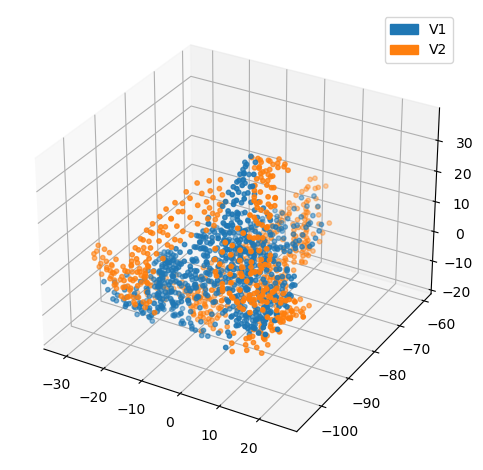

In [37]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter(*dfv_[['x', 'y', 'z']].T.to_numpy(), s=10, c=[roi_colors_[pl] for pl in dfv_['parcellation_label']])
ax.legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in roi_colors_.items()])
plt.tight_layout()

## Visual Analysis

In [38]:
metric = 'ecc'
metric_limit = 3

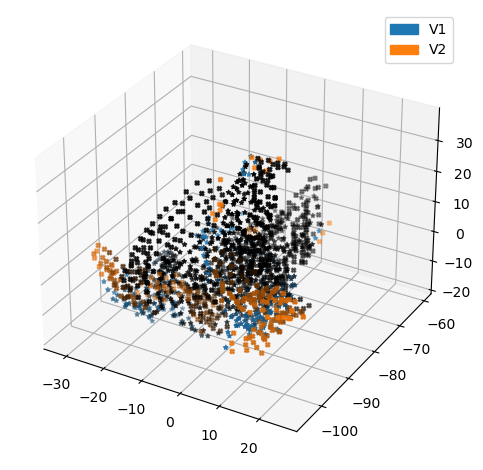

In [39]:
%matplotlib inline
ax = plt.axes(projection='3d')
for roi_label in roi_:
    ax.scatter(*dfv_[dfv_['parcellation_label'] == roi_label][['x', 'y', 'z']].T.to_numpy(),
               s=10, marker=roi_markers_[roi_label],
               c=[np.array(roi_colors_[roi_label]) * relu(1 - met/metric_limit) for met in dfv_[dfv_['parcellation_label'] == roi_label][metric]]
    )
ax.legend(handles=[mpatches.Patch(color=roi_color, label=roi_label) for roi_label, roi_color in roi_colors_.items()])
plt.tight_layout()

/kyb/agzl/pgoyal/miniconda3/envs/hcp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


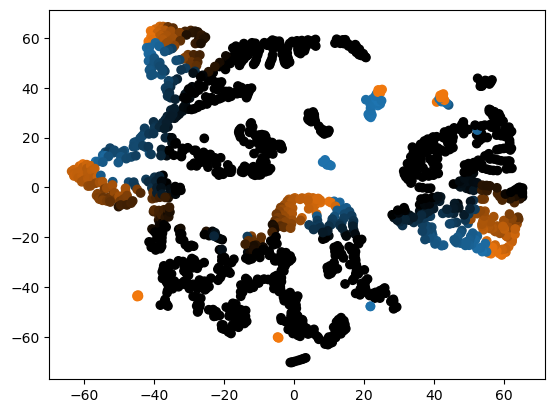

In [40]:
# %%capture --no-stdout
plt.scatter(*TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=10).fit_transform(dfv_[['x', 'y', 'z', 'ecc']]).T, # 'ang', 'rfsize'
            c=np.array([roi_colors_[pl] for pl in dfv_['parcellation_label']]) * np.array([relu(1 - ecc/3) for ecc in dfv_['ecc']])[:, None]);

## Analysis

In [41]:
ang_mesh = np.linspace(0, 360, 61)
ecc_mesh = np.logspace(0, 4, 9, base=2) - 1 # np.r_[0, np.logspace(1, np.log2(df[metric].max().round(-1)), 4, base=2)]

In [42]:
def analyse(df_grp, metric, mesh):
    def wrapper(grp_par):
        grp_par_metric = grp_par.groupby(pd.cut(dfv_[metric], mesh))
        return grp_par_metric.mean(numeric_only=True).join(grp_par_metric.std(), rsuffix='_other')[['x', 'y', 'z'] + ['x_other', 'y_other', 'z_other']]
    df_grp_ = df_grp.apply(wrapper)
    df_grp_[['dx', 'dy', 'dz']] = (lambda x: x - x.shift(1 - len(mesh)))(df_grp_[['x', 'y', 'z']])
    df_grp_['d'] = np.sqrt(np.sum(df_grp_[['dx', 'dy', 'dz']].pow(2), axis=1))
    # Improv.: https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    return df_grp_[['dx', 'dy', 'dz'] + ['d']]

In [43]:
dfv_par = dfv_.groupby('parcellation_label')

In [44]:
dfv_par_metric = analyse(dfv_par, metric, mesh:=ecc_mesh)

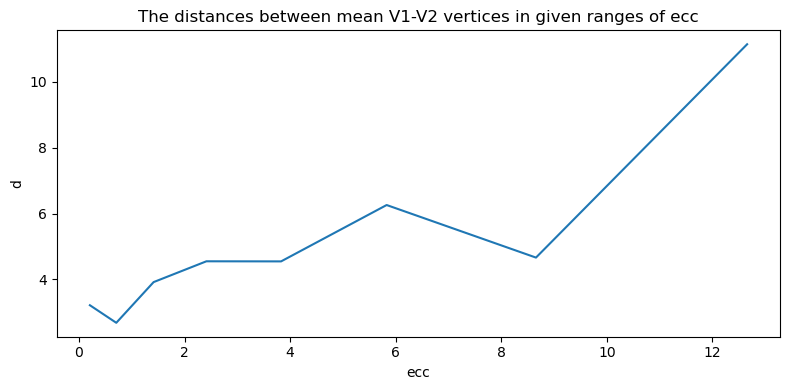

In [45]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(dfv_par_metric.loc['V1'], x=(mesh[:-1] + mesh[1:])/2, y='d', ax=ax)
ax.set_xlabel(metric)
ax.set_title(f'The distances between mean {"-".join(roi_)} vertices in given ranges of {metric}')
plt.tight_layout()